In [1]:
import sys
import os
import time
import datetime as dt
import math
import numpy as np 
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pingouin as pg
from scipy.signal import butter,filtfilt
from scipy import interpolate
from scipy.interpolate import interp1d

import activityanalysis_test as act
import respy_test as respy

In [2]:
# conditions for comparison 246900 289766
units = 1000 # ms
fs = 50/units # 10 Hz

cutoff = np.array([0.5])/units # filtering to between 1 and 0.05 hz
nyq = 1 * fs 
order = 2 
normal_cutoff = cutoff / nyq
b, a = butter(order, normal_cutoff, btype='lowpass', analog=False)

In [3]:
os.chdir('/Users/finn/Desktop/Current_Projects/Resp_Mobile_recording/Mobile_test/Data/')
trial_wise = pd.read_csv('trial_wise.csv')
trial_seq = pd.read_csv('Trial_Stim.csv')
trial_times=trial_seq.iloc[:,:2].copy()

trial_times['Time (ms)'] = units*trial_times['Time (s)']
trial_times=trial_times.set_index("Time (ms)", drop=True)
trial_times

,Time (s),Element
Time (ms),,
0.0,0.000,Trial number
2136.0,2.136,Part 1 Synchronisation
20000.0,20.000,taps
23450.0,23.450,Part 2 Listening task 1
32000.0,32.000,Silence 1
62000.0,62.000,Music 1
92500.0,92.500,Part 3 Moving tasks
101000.0,101.000,Verbalise
112000.0,112.000,Move


# Condensed single trial
gather all three signals for a single trial and confirm their alignment with crosscorrelations on subsections of the trails

In [44]:
# trial timing information
trial_n =10
theta = np.pi*2*25/360 # phone angle

# Trial to test
trial_name = trial_wise.loc[trial_n,'Participant'] + '_' + trial_wise.loc[trial_n,'Trial stim']

#import the three sets of sensor data
# mobile app data
os.chdir('/Users/finn/Desktop/Current_Projects/Resp_Mobile_recording/Mobile_test/Data/Acc/')
df = pd.read_csv(trial_wise.loc[trial_n,'Mobile_file'])
df['Time (ms)'] = (df['time']-df['time'].loc[0])-(trial_wise.loc[trial_n,'Stim']-trial_wise.loc[trial_n,'Mobile start'])*units # Time is time zero
time_new = np.arange(df['Time (ms)'].iat[0],df['Time (ms)'].iat[-1],1/fs)
df_rs = pd.DataFrame()
df_rs['Time (ms)'] = time_new
df_rs = df_rs.set_index('Time (ms)')
df_rs['Time (s)'] = time_new/1000
cols = ['x', 'y', 'z', 'alpha', 'beta', 'gamma']
for c in cols:
    f = interpolate.interp1d(df['Time (ms)'], df[c].values,fill_value='extrapolate')
    df_rs[c] = f(time_new)-np.median(f(time_new))
    df_rs['filt ' + c] = filtfilt(b, a, df_rs[c])
    df_rs['diff ' + c] = respy.diffed(df_rs['filt ' + c])/np.median(np.abs(respy.diffed(respy.diffed(df_rs['filt ' + c]))))
mob_rs = df_rs.copy()

# respiration belt data
os.chdir('/Users/finn/Documents/uio-ritmo/Sweetzpot Data/' + str(trial_wise.loc[trial_n,'Resp_file']) + '/')
filename = 'Breathing2.csv'
g = pd.read_csv(filename,',',header=None,names=['0','1','2','3','4','5'])
resp_init = g.loc[g['1']=='force']
respdelay = np.round(resp_init.iloc[0,0] - g.iloc[0,0],-2)
print('resp belt sensor connection delay ' + str(respdelay/1000) + 's' ) #rounded to 10 hz

# motion capture recordings
os.chdir('/Users/finn/Desktop/Current_Projects/Resp_Mobile_recording/Mobile_test/Data/MC/')
m = pd.read_csv(trial_wise.loc[trial_n,'mocap_file'], sep='\t',header=None,names=['HEADT X', 'HEADT Y', 'HEADT Z', 'SHL X', 'SHL Y','SHL Z','SHR X', 'SHR Y', 'SHR Z','CH X', 'CH Y', 'CH Z'])
mocap = m.loc[~m['CH Z'].isna(),:].copy()#.astype(float)
mocap = mocap.iloc[1:,:]
mocap.loc[:,'Time (ms)'] = (np.arange(0,len(mocap),)*units/120) - trial_wise.loc[trial_n,'Stim']*units
trial_wise.loc[trial_n,:]

resp belt sensor connection delay 13.1s


filename                       KB_Trial_03.qtm
Data type                               Mocap 
Resp start                                 5.0
Mobile start                               9.0
Stim                                        14
Trial stim                                  T3
Participant                                 KB
Trial order                                 11
Mobile loc                                   6
Music Move                              Seated
Move Act                 lean forward and back
Resp_file                        1615899258679
Mobile_file     data_part2_trial_3_Stim_T3.csv
mocap_file                     KB_Trial_03.tsv
Name: 10, dtype: object

In [45]:
trial_times

,Time (s),Element
Time (ms),,
0.0,0.000,Trial number
2136.0,2.136,Part 1 Synchronisation
20000.0,20.000,taps
23450.0,23.450,Part 2 Listening task 1
32000.0,32.000,Silence 1
62000.0,62.000,Music 1
92500.0,92.500,Part 3 Moving tasks
101000.0,101.000,Verbalise
112000.0,112.000,Move


In [52]:
(df['time'].diff().mode()/1000)

0    0.017
dtype: float64

(-7.0, -5.0)

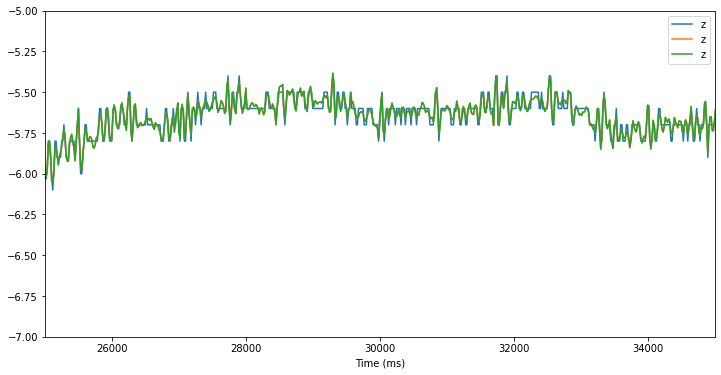

In [63]:
# sanity check on dropping precising of iphone acc output to 4 decimals. 
# Result: Hardly anything missed, but 1 decimal may be going too far.
fig = plt.figure(figsize=(12,6))
ax = plt.subplot(111)
A = df.copy()
A.loc[:,'z']=A['z'].round(1)
A.plot.line(x = 'Time (ms)', y = 'z', ax=ax)
A = df.copy()
A.loc[:,'z']=A['z'].round(4)
A.plot.line(x = 'Time (ms)', y = 'z', ax=ax)
df.plot.line(x = 'Time (ms)', y = 'z', ax=ax)

t_range = np.array([25,35])*units
plt.xlim(t_range)
plt.ylim([-7,-5])

In [48]:
df.max()

timestamp    1.615899e+12
time         1.173619e+06
x            1.100540e+01
y            1.445799e+00
z           -1.211948e-02
alpha        2.188452e+01
beta         1.553973e+02
gamma        3.171985e+01
Time (ms)    2.720660e+05
dtype: float64

timestamp     29.000000
time          28.000000
x              1.691803
y              1.307234
z              5.743691
alpha         24.045384
beta         166.019765
gamma         19.398103
Time (ms)     28.000000
dtype: float64


(0.0, 1.0)

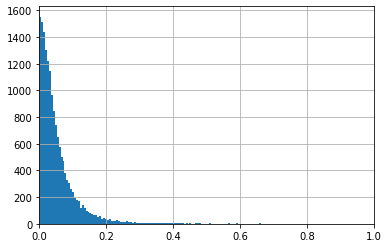

In [49]:
print(df.diff().abs().max())
df['z'].diff().abs().hist(bins=1000)
plt.xlim([0,1])


# Sync mobile with taps
script to sync stimulus to mobile data using the timing of the three synch taps

First detect the location of the three taps, then adjust the time vector to stimulus zero

(15000.0, 25000.0)

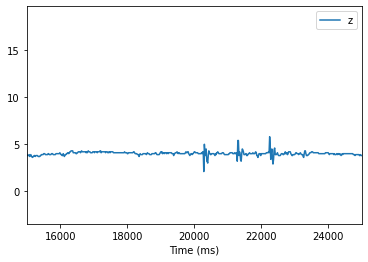

In [22]:
t_range = np.array([15,25])*units
#df['z'].plot()
df.plot.line(x = 'Time (ms)', y = 'z')
plt.xlim(t_range)

# mob_rs['z'].diff().plot()
# plt.xlim(t_range)

In [23]:
df

,timestamp,time,x,y,z,alpha,beta,gamma,Time (ms)
0,1615819710731,3733374.4,-8.9,0.8,5.3,-8.0,0.3,0.3,-10000.0
1,1615819710748,3733391.1,-8.9,0.6,5.1,5.2,0.2,-0.7,-9983.3
2,1615819710764,3733407.8,-8.9,0.7,4.2,5.1,-1.2,-0.9,-9966.6
3,1615819710781,3733424.5,-8.9,0.9,4.4,0.9,-5.9,-0.2,-9949.9
4,1615819710798,3733441.1,-8.8,0.9,4.5,0.9,-8.8,-0.5,-9933.3
...,...,...,...,...,...,...,...,...,...
16952,1615819993253,4015896.6,-9.3,1.0,5.6,-24.2,1.1,5.3,272522.2
16953,1615819993270,4015913.2,-9.3,0.6,5.1,-8.8,0.7,2.2,272538.8
16954,1615819993286,4015929.9,-9.3,0.7,5.5,4.1,-0.9,-3.2,272555.5
16955,1615819993303,4015946.5,-9.1,0.9,5.9,20.5,-7.6,-0.1,272572.1


In [24]:
df.max()

timestamp    1.615820e+12
time         4.015966e+06
x           -6.600000e+00
y            4.200000e+00
z            1.860000e+01
alpha        6.450000e+01
beta         5.719000e+02
gamma        2.630000e+01
Time (ms)    2.725920e+05
dtype: float64

timestamp    8.0
time         9.8
x            0.0
y            0.0
z            0.0
alpha        0.0
beta         0.0
gamma        0.0
Time (ms)    9.8
dtype: float64


array([[<AxesSubplot:title={'center':'timestamp'}>,
        <AxesSubplot:title={'center':'time'}>,
        <AxesSubplot:title={'center':'x'}>],
       [<AxesSubplot:title={'center':'y'}>,
        <AxesSubplot:title={'center':'z'}>,
        <AxesSubplot:title={'center':'alpha'}>],
       [<AxesSubplot:title={'center':'beta'}>,
        <AxesSubplot:title={'center':'gamma'}>,
        <AxesSubplot:title={'center':'Time (ms)'}>]], dtype=object)

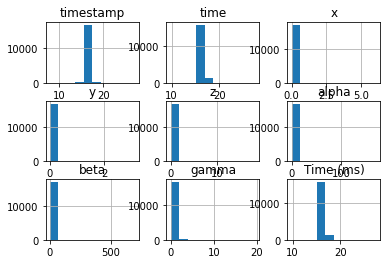

In [26]:
print(df.diff().abs().min())
df.diff().abs().hist()